In this notebook, I will do the crossmatch between two decimation solutions (A and B), calculate the radio source position differences and remove the outliers in order to obtain a clean sample for further analysis.

In [19]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# File name: decimation_solution_xmatch.py
"""
Created on Thu Jun 21 09:30:04 2018

@author: Neo(liuniu@smail.nju.edu.cn)
"""

from astropy.table import Table, join, Column, setdiff
import matplotlib.pyplot as plt
import numpy as np
# from numpy import cos, deg2rad, sqrt
%matplotlib inline
%config InlineBackend.figure_format = "svg"
# My modules
from my_progs.catalog.pos_diff import pos_diff_calc
from my_progs.catalog.pos_err import pos_err_calc

First, I read the source position information from two VLBI decimation solutions.
They are stored in two astropy.Table objects.

In [20]:
# Read solutions A and B
t1 = Table.read("../data/deci-test1b.cat", format="ascii",
                names=["ivs_name", "iers_name", "ra", "dec",
                       "ra_err", "dec_err", "ra_dec_corr",
                       "epo_mean", "epo_beg", "epo_end",
                       "num_sess", "num_obs", "num_obsr", "flg"],
                exclude_names=["epo_mean", "epo_beg", "epo_end", "num_obsr", "flg"])

t2 = Table.read("../data/deci-test2b.cat", format="ascii",
                names=["ivs_name", "iers_name", "ra", "dec",
                       "ra_err", "dec_err", "ra_dec_corr",
                       "epo_mean", "epo_beg", "epo_end",
                       "num_sess", "num_obs", "num_obsr", "flg"],
                exclude_names=["iers_name", "epo_mean", "epo_beg", "epo_end", "num_obsr", "flg"])

Then I calculate the semi-major axis of the error ellipse (EEMA, following Sebsetien's notation) which character the positional error.
This quantity is added to the Table object.

In [21]:
# Calculate the error ellipse major axis
eema1 = pos_err_calc(t1["ra_err"], t1["dec_err"], t1["ra_dec_corr"])
t1.add_column(eema1, name="eema")
eema2 = pos_err_calc(t2["ra_err"], t2["dec_err"], t2["ra_dec_corr"])
t2.add_column(eema2, name="eema")

Then, I print the median formal error of two solutions.

In [22]:
print("\n# Decimation solution A:\n", t1,
      "\n median formal error in R.A. (mas): ", np.median(t1["ra_err"]),
      "\n median formal error in Decl. (mas): ", np.median(t1["dec_err"]),
      "\n median EEMA (mas):", np.median(t1["eema"]))

print("\n# Decimation solution B:\n", t2,
      "\n median formal error in R.A. (mas): ", np.median(t2["ra_err"]),
      "\n median formal error in Decl. (mas): ", np.median(t2["dec_err"]),
      "\n median EEMA (mas):", np.median(t2["eema"]))


# Decimation solution A:
 ivs_name iers_name       ra       ... num_sess num_obs         eema        
-------- --------- -------------- ... -------- ------- --------------------
2357-326  2357-326   0.0849999532 ...        1     104  0.31959770898741374
2358+406  2358+406   0.2211708661 ...        1      91  0.21985523518098754
2358-161  2358-161    0.272203079 ...        2     173  0.25345262715188427
2358+189  2358+189   0.2859232024 ...       82    1435  0.04040296865394717
2359-221  2359-221   0.5499227745 ...        2      19   1.2476574447125812
0000-199  0000-199   0.8164559038 ...        1      99  0.33242085212508043
0000-197  0000-197   0.8278126268 ...        2     142  0.41846144294292836
0000+212  0000+212   0.8306250613 ...        1      35   0.7882839202955324
0000-160  0000-160   0.8636005966 ...        2     100  0.41649456472995583
0001+478  0001+478   0.9418378991 ...        1       1   149.32107458596252
     ...       ...            ... ...      ...     ...       

Next, I cross-match the two solutions, giving a subset of 2754 common sources.

In [23]:
# Cross-match
t_com0 = join(t1, t2, keys="ivs_name")
print("\n# Catalog after cross-match:\n", t_com0)


# Catalog after cross-match:
 ivs_name iers_name      ra_1      ... num_sess_2 num_obs_2        eema_2       
-------- --------- -------------- ... ---------- --------- --------------------
0000+212  0000+212   0.8306250613 ...          1        31   1.5333451904130648
0000-160  0000-160   0.8636005966 ...          1        77   0.5216359431973622
0000-197  0000-197   0.8278126268 ...          2        91    0.646244601770531
0000-199  0000-199   0.8164559038 ...          2        83  0.45703774776344186
0001+459  0001+459   1.0671985464 ...          2       197  0.10593508627593047
0001+478  0001+478   0.9418378991 ...          2       131  0.34431045179229125
0001-120  0001-120    1.020479184 ...          1         9   1.9505311499586664
0002+051  0002+051   1.3342312733 ...          1        70  0.38726776173473765
0002+200  0002+200    1.148992966 ...          1        22  0.31767563760653234
0002+541  0002+541    1.268180627 ...          1        25  0.27755937458916513
     ... 

What I am interested in is the position difference between these two solutions. Calculate it!

In [24]:
# Calculte the positional difference
[dra, ddec, dra_err, ddec_err, dra_ddec_cor,
 ang_sep, X_a, X_d, X, _] = pos_diff_calc(
    t_com0["ra_1"], t_com0["ra_err_1"], t_com0["dec_1"], t_com0["dec_err_1"], t_com0["ra_dec_corr_1"],
    t_com0["ra_2"], t_com0["ra_err_2"], t_com0["dec_2"], t_com0["dec_err_2"], t_com0["ra_dec_corr_2"])

# Choose the maximum EEMA of two decimation solutions to consist the EEMA
eema = Column(np.where(t_com0["eema_1"] <= t_com0["eema_2"],
                t_com0["eema_1"], t_com0["eema_2"]))

t_com0.add_columns([dra, ddec, dra_err, ddec_err, dra_ddec_cor, eema, ang_sep, X],
                   names=["dra", "ddec", "dra_err", "ddec_err", "dra_ddec_cor", "eema", "ang_sep", "X"])

# Mean number of sessions and observations
num_ses_mean = (t_com0["num_sess_1"] + t_com0["num_sess_2"]) / 2
num_obs_mean = (t_com0["num_obs_1"] + t_com0["num_obs_2"]) / 2
t_com0.add_columns([num_ses_mean, num_obs_mean],
                   names=["num_ses_mean", "num_obs_mean"])

In [25]:
t_com0.colnames

['ivs_name',
 'iers_name',
 'ra_1',
 'dec_1',
 'ra_err_1',
 'dec_err_1',
 'ra_dec_corr_1',
 'num_sess_1',
 'num_obs_1',
 'eema_1',
 'ra_2',
 'dec_2',
 'ra_err_2',
 'dec_err_2',
 'ra_dec_corr_2',
 'num_sess_2',
 'num_obs_2',
 'eema_2',
 'dra',
 'ddec',
 'dra_err',
 'ddec_err',
 'dra_ddec_cor',
 'eema',
 'ang_sep',
 'X',
 'num_ses_mean',
 'num_obs_mean']

94 sources with less than 3 observations in either solution are removed.

In [26]:
# Remove Sources with observations less than 3
mask0 = (t_com0["num_obs_1"] >= 3) & (t_com0["num_obs_2"] >= 3)
t_com1 = t_com0[mask0]
print("\n# Catalog after removing Sources with observations less than 3:\n", t_com1)


# Catalog after removing Sources with observations less than 3:
 ivs_name iers_name      ra_1      ... num_ses_mean num_obs_mean
-------- --------- -------------- ... ------------ ------------
0000+212  0000+212   0.8306250613 ...          1.0         33.0
0000-160  0000-160   0.8636005966 ...          1.5         88.5
0000-197  0000-197   0.8278126268 ...          2.0        116.5
0000-199  0000-199   0.8164559038 ...          1.5         91.0
0001+459  0001+459   1.0671985464 ...          1.5        136.5
0001-120  0001-120    1.020479184 ...          2.0        122.0
0002+051  0002+051   1.3342312733 ...          1.0         48.0
0002+200  0002+200    1.148992966 ...          1.5         50.5
0002+541  0002+541    1.268180627 ...          2.0        134.5
0002-170  0002-170   1.3247241525 ...          1.5        135.5
     ...       ...            ... ...          ...          ...
 NRAO512  1638+398  250.123469875 ...        821.0      66596.5
 NRAO530  1730-130  263.261274122 ... 

In addition, I set an upper limit of 1 mas on the EEMA and 3.97 on the normalized separation.
This process kept a clean sample of 2380 sources.

In [27]:
# For Gaussian error, the normalized difference X is expected to follow the Reigh distribution
# which means Pr(X>x) = exp(-x^x/2)
X0 = np.sqrt(-np.log(1. / len(t_com1)) * 2)

print("X0 = ", X0)

X0 =  3.971418235788254


In [28]:
# Masked data
mask = (t_com1["eema"] <= 1) & (t_com1["X"] <= X0)
t_com2 = t_com1[mask]
print(t_com2)

ivs_name iers_name      ra_1      ... num_ses_mean num_obs_mean
-------- --------- -------------- ... ------------ ------------
0000+212  0000+212   0.8306250613 ...          1.0         33.0
0000-160  0000-160   0.8636005966 ...          1.5         88.5
0000-197  0000-197   0.8278126268 ...          2.0        116.5
0000-199  0000-199   0.8164559038 ...          1.5         91.0
0001+459  0001+459   1.0671985464 ...          1.5        136.5
0001-120  0001-120    1.020479184 ...          2.0        122.0
0002+051  0002+051   1.3342312733 ...          1.0         48.0
0002+200  0002+200    1.148992966 ...          1.5         50.5
0002+541  0002+541    1.268180627 ...          2.0        134.5
0002-170  0002-170   1.3247241525 ...          1.5        135.5
     ...       ...            ... ...          ...          ...
 NRAO140  0333+321  54.1254483689 ...         82.5       1874.0
 NRAO150  0355+508  59.8739469584 ...        470.0      13301.0
 NRAO190  0440-003  70.6610863288 ...   

In [29]:
# Masked data
mask = (t_com2["num_ses_mean"] >= 5)
t_com3 = t_com2[mask]
print(t_com3)

ivs_name iers_name      ra_1      ... num_ses_mean num_obs_mean
-------- --------- -------------- ... ------------ ------------
0002-478  0002-478   1.1485645333 ...         30.0        217.5
0003+380  0003+380   1.4882307968 ...         14.5        904.5
0003-066  0003-066   1.5578870351 ...        895.0      21865.5
0010+405  0010+405    3.379709177 ...         39.0       2008.5
0013-005  0013-005   4.0462023009 ...         48.0        694.0
0016+731  0016+731   4.9407765511 ...        438.5      60235.0
0017+200  0017+200   4.9077270637 ...        141.0      19810.5
0019+058  0019+058   5.6351717182 ...        185.5       3860.5
0021+243  0021+243   6.1138772451 ...          7.0         99.5
0025+197  0025+197   7.1242436754 ...         57.5       1521.5
     ...       ...            ... ...          ...          ...
 NGC6251  1637+826  248.133207777 ...        140.0       4732.0
 NGC6454  1744+557   266.23586278 ...         14.5        551.5
 NRAO140  0333+321  54.1254483689 ...   

For further reference and use, I wirte the all the necessary information into text files.

In [30]:
# For all sources
import time
import sys

t_com0.meta["comments"] = [
    " Radio source position difference from decimation tests (All sources)",
    " Columns  Units   Meaning",
    "    1     --      IVS designation",
    "    2     deg     Right ascension(odd session)",
    "    3     deg     Declination(odd session)",
    "    4     mas     Difference of RA*cos(Dec)",
    "    5     mas     Difference of Declination",
    "    6     mas     Formal uncertainty of difference in RA*cos(Dec)",
    "    7     mas     Formal uncertainty of difference in declination",
    "    8     mas     Minimum semi-major axis of error ellipse",
    "    9     mas     Angular separation",
    "   10      -      Normalized separation",
    "   10      -      Mean number of sessions in two solutions",
    "   11      -      Mean number of observations in two solutions",
    " Created date: %s by decimation_solution_xmatch.ipynb." % time.strftime(
        "%d/%m/%Y", time.localtime()),
    " Original data: ../data/deci-test{1,2}b.cat"]

t_com0.write("../logs/pos_diff_all.dat",
             format="ascii.fixed_width_no_header", delimiter="",
             include_names=["ivs_name", "ra_1", "dec_1",
                            "dra", "ddec", "dra_err", "ddec_err",
                            "eema", "ang_sep", "X",
                            "num_ses_mean", "num_obs_mean"],
             formats={"ivs_name": "%8s",
                      "ra_1": "%14.10f", "dec_1": "%+14.10f",
                      "dra": "%+10.4f", "ddec": "%+10.4f",
                      "dra_err": "%10.4f", "ddec_err": "%10.4f",
                      "eema": "%10.4f", "ang_sep": "%10.4f", "X": "%6.2f",
                      "num_ses_mean": "%6d", "num_obs_mean": "%8d"},
             overwrite=True)

In [31]:
# For the clean sample 01
import time
import sys

t_com2.meta["comments"] = [
    " Radio source position difference from decimation tests (Clean sample)",
    " Columns  Units   Meaning",
    "    1      -      IVS designation",
    "    2     deg     Right ascension(odd session)",
    "    3     deg     Declination(odd session)",
    "    4     mas     Difference of RA*cos(Dec)",
    "    5     mas     Difference of Declination",
    "    6     mas     Formal uncertainty of difference in RA*cos(Dec)",
    "    7     mas     Formal uncertainty of difference in declination",
    "    8     mas     Minimum semi-major axis of error ellipse",
    "    9     mas     Angular separation",
    "   10      -      Normalized separation",
    "   10      -      Mean number of sessions in two solutions",
    "   11      -      Mean number of observations in two solutions",
    " Created date: %s by decimation_solution_xmatch.ipynb." % time.strftime(
        "%d/%m/%Y", time.localtime()),
    " Original data: ../data/deci-test{1,2}b.cat"]

t_com2.write("../logs/pos_diff_cln01.dat",
             format="ascii.fixed_width_no_header", delimiter="",
             include_names=["ivs_name", "ra_1", "dec_1",
                            "dra", "ddec", "dra_err", "ddec_err",
                            "eema", "ang_sep", "X",
                            "num_ses_mean", "num_obs_mean"],
             formats={"ivs_name": "%8s",
                      "ra_1": "%14.10f", "dec_1": "%+14.10f",
                      "dra": "%+10.4f", "ddec": "%+10.4f",
                      "dra_err": "%10.4f", "ddec_err": "%10.4f",
                      "eema": "%10.4f", "ang_sep": "%10.4f", "X": "%6.2f",
                      "num_ses_mean": "%6d", "num_obs_mean": "%8d"},
             overwrite=True)

In [32]:
# For the clean sample
import time
import sys

t_com3.meta["comments"] = [
    " Radio source position difference from decimation tests (Clean sample)",
    " Columns  Units   Meaning",
    "    1      -      IVS designation",
    "    2     deg     Right ascension(odd session)",
    "    3     deg     Declination(odd session)",
    "    4     mas     Difference of RA*cos(Dec)",
    "    5     mas     Difference of Declination",
    "    6     mas     Formal uncertainty of difference in RA*cos(Dec)",
    "    7     mas     Formal uncertainty of difference in declination",
    "    8     mas     Minimum semi-major axis of error ellipse",
    "    9     mas     Angular separation",
    "   10      -      Normalized separation",
    "   10      -      Mean number of sessions in two solutions",
    "   11      -      Mean number of observations in two solutions",
    " Created date: %s by decimation_solution_xmatch.ipynb." % time.strftime(
        "%d/%m/%Y", time.localtime()),
    " Original data: ../data/deci-test{1,2}b.cat"]

t_com3.write("../logs/pos_diff_cln.dat",
             format="ascii.fixed_width_no_header", delimiter="",
             include_names=["ivs_name", "ra_1", "dec_1",
                            "dra", "ddec", "dra_err", "ddec_err",
                            "eema", "ang_sep", "X",
                            "num_ses_mean", "num_obs_mean"],
             formats={"ivs_name": "%8s",
                      "ra_1": "%14.10f", "dec_1": "%+14.10f",
                      "dra": "%+10.4f", "ddec": "%+10.4f",
                      "dra_err": "%10.4f", "ddec_err": "%10.4f",
                      "eema": "%10.4f", "ang_sep": "%10.4f", "X": "%6.2f",
                      "num_ses_mean": "%6d", "num_obs_mean": "%8d"},
             overwrite=True)

I plot the distribution of the normalized separation as a function of the minimum semi-major axis of the error ellipse.

In [33]:
# Read ICRF2 data
t_soutype = Table.read("../data/icrf2.dat", format="ascii",
                       names=["icrf_name", "ivs_name", "iers_name", "sou_type",
                              "ra_h", "ra_m", "ra_s", "dec_h", "dec_m", "dec_s",
                              "ra_err", "dec_err", "ra_dec_corr",
                              "epo_mean", "epo_beg", "epo_end",
                              "num_sess", "num_obs"],
                       include_names=["ivs_name", "sou_type"])

# Find VCS sources
t_vcs0 = join(t_soutype[t_soutype["sou_type"] == "V"], t_com0, keys="ivs_name")

# Find non-VCS sources
t_nonvcs0 = setdiff(t_com0, t_vcs0, keys="ivs_name")

print("\n# VCS source:\n", t_vcs0,
      "\n median difference in R.A. (mas): ", np.median(t_vcs0["dra"]),
      "\n median difference in Decl. (mas): ", np.median(t_vcs0["ddec"]),
      "\n median EEMA (mas):", np.median(t_vcs0["eema"]),
      "\n median normalized difference:", np.median(t_vcs0["X"]))
print("\n# Non-VCS source:\n", t_nonvcs0,
      "\n median difference in R.A. (mas): ", np.median(t_nonvcs0["dra"]),
      "\n median difference in Decl. (mas): ", np.median(t_nonvcs0["ddec"]),
      "\n median EEMA (mas):", np.median(t_nonvcs0["eema"]),
      "\n median normalized difference:", np.median(t_nonvcs0["X"]))


# VCS source:
 ivs_name sou_type iers_name ...          X          num_ses_mean num_obs_mean
-------- -------- --------- ... ------------------- ------------ ------------
0000+212        V  0000+212 ... 0.10444008431944148          1.0         33.0
0000-197        V  0000-197 ...  0.8050682909330577          2.0        116.5
0000-199        V  0000-199 ...  2.7824661551023016          1.5         91.0
0001+459        V  0001+459 ...  1.5852736750088465          1.5        136.5
0001-120        V  0001-120 ...  0.5521800268520314          2.0        122.0
0002+051        V  0002+051 ...   1.475852369487872          1.0         48.0
0002+541        V  0002+541 ...  1.1691653731630518          2.0        134.5
0002-170        V  0002-170 ...  0.9623269463187764          1.5        135.5
0003-302        V  0003-302 ...  0.9940873166182229          1.0         34.5
0004+240        V  0004+240 ... 0.47386627579741414          1.0         29.5
     ...      ...       ... ...                 

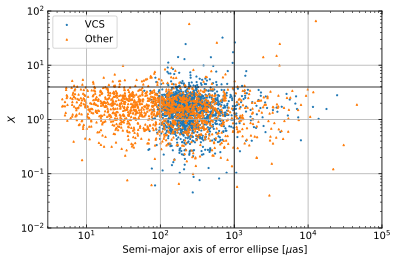

In [34]:
# Plot for the normalized difference
fig, ax = plt.subplots()
ax.scatter(t_vcs0["eema"] * 1.e3, t_vcs0["X"], s=2, marker="*",
           label="VCS")
ax.scatter(t_nonvcs0["eema"] * 1.e3, t_nonvcs0["X"], s=2, marker="^",
           label="Other")

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim([0.003, 100])
ax.set_xlim([3, 1e5])
ax.set_ylim([0.01, 100])
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

# ax.set_xlabel("Semi-major axis of error ellipse [mas]")
# ax.hlines(X0, 0.003, 100, linestyles="solid", lw=0.8)
# ax.vlines(1, 0.01, 100, linestyles="solid", lw=0.8)

ax.hlines(X0, 3, 1e5, linestyles="solid", lw=0.8)
ax.vlines(1000, 0.01, 100, linestyles="solid", lw=0.8)
ax.set_xlabel("Semi-major axis of error ellipse [$\mu$as]")

ax.set_ylabel("$X$")

plt.grid()
plt.legend()
# plt.savefig("../plots/x-eema_all.eps")

In [35]:
# Find VCS sources
t_vcs = join(t_soutype[t_soutype["sou_type"] == "V"], t_com1, keys="ivs_name")

# Find non-VCS sources
t_nonvcs = setdiff(t_com1, t_vcs, keys="ivs_name")

print("\n# VCS source:\n", t_vcs,
      "\n median difference in R.A. (mas): ", np.median(t_vcs["dra"]),
      "\n median difference in Decl. (mas): ", np.median(t_vcs["ddec"]),
      "\n median EEMA (mas):", np.median(t_vcs["eema"]),
      "\n median normalized difference:", np.median(t_vcs["X"]))
print("\n# Non-VCS source:\n", t_nonvcs,
      "\n median difference in R.A. (mas): ", np.median(t_nonvcs["dra"]),
      "\n median difference in Decl. (mas): ", np.median(t_nonvcs["ddec"]),
      "\n median EEMA (mas):", np.median(t_nonvcs["eema"]),
      "\n median normalized difference:", np.median(t_nonvcs["X"]))


# VCS source:
 ivs_name sou_type iers_name ...          X          num_ses_mean num_obs_mean
-------- -------- --------- ... ------------------- ------------ ------------
0000+212        V  0000+212 ... 0.10444008431944148          1.0         33.0
0000-197        V  0000-197 ...  0.8050682909330577          2.0        116.5
0000-199        V  0000-199 ...  2.7824661551023016          1.5         91.0
0001+459        V  0001+459 ...  1.5852736750088465          1.5        136.5
0001-120        V  0001-120 ...  0.5521800268520314          2.0        122.0
0002+051        V  0002+051 ...   1.475852369487872          1.0         48.0
0002+541        V  0002+541 ...  1.1691653731630518          2.0        134.5
0002-170        V  0002-170 ...  0.9623269463187764          1.5        135.5
0003-302        V  0003-302 ...  0.9940873166182229          1.0         34.5
0004+240        V  0004+240 ... 0.47386627579741414          1.0         29.5
     ...      ...       ... ...                 

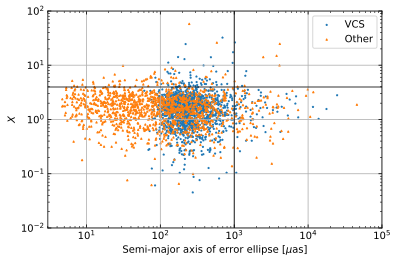

In [36]:
# Plot for the normalized difference
fig, ax = plt.subplots()
ax.scatter(t_vcs["eema"] * 1.e3, t_vcs["X"], s=2, marker="*",
           label="VCS")
ax.scatter(t_nonvcs["eema"] * 1.e3, t_nonvcs["X"], s=2, marker="^",
           label="Other")

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim([0.003, 100])
ax.set_xlim([3, 1e5])
ax.set_ylim([0.01, 100])
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

# ax.set_xlabel("Semi-major axis of error ellipse [mas]")
# ax.hlines(X0, 0.003, 100, linestyles="solid", lw=0.8)
# ax.vlines(1, 0.01, 100, linestyles="solid", lw=0.8)

ax.hlines(X0, 3, 1e5, linestyles="solid", lw=0.8)
ax.vlines(1000, 0.01, 100, linestyles="solid", lw=0.8)
ax.set_xlabel("Semi-major axis of error ellipse [$\mu$as]")

ax.set_ylabel("$X$")

plt.grid()
plt.legend()
plt.savefig("../plots/x-eema.eps")

In [38]:
# Find VCS sources
t_vcs = join(t_soutype[t_soutype["sou_type"] == "V"], t_com3, keys="ivs_name")

# Find non-VCS sources
t_nonvcs = setdiff(t_com3, t_vcs, keys="ivs_name")

print("\n# %d VCS source:\n" % len(t_vcs), t_vcs,
      "\n median difference in R.A. (mas): ", np.median(t_vcs["dra"]),
      "\n median difference in Decl. (mas): ", np.median(t_vcs["ddec"]),
      "\n median EEMA (mas):", np.median(t_vcs["eema"]),
      "\n median normalized difference:", np.median(t_vcs["X"]))
print("\n# %d Non-VCS source:\n" % len(t_nonvcs), t_nonvcs,
      "\n median difference in R.A. (mas): ", np.median(t_nonvcs["dra"]),
      "\n median difference in Decl. (mas): ", np.median(t_nonvcs["ddec"]),
      "\n median EEMA (mas):", np.median(t_nonvcs["eema"]),
      "\n median normalized difference:", np.median(t_nonvcs["X"]))


# 6 VCS source:
 ivs_name sou_type iers_name ...          X          num_ses_mean num_obs_mean
-------- -------- --------- ... ------------------- ------------ ------------
0730+504        V  0730+504 ...  0.6109866750391101          5.0        343.5
1319-093        V  1319-093 ...  1.1696268918500818          6.0        334.0
1336-237        V  1336-237 ... 0.43197896348705966          5.0        147.5
1550-242        V  1550-242 ...  2.6617185237081538         17.5        434.5
1842-289        V  1842-289 ...   1.894108056254388          5.5        184.0
2354-117        V  2354-117 ...  0.9059516398215413          6.5        266.5 
 median difference in R.A. (mas):  -0.03608473541586721 
 median difference in Decl. (mas):  0.006299997323822026 
 median EEMA (mas): 0.11757625036368573 
 median normalized difference: 1.0377892658358117

# 703 Non-VCS source:
 ivs_name iers_name      ra_1      ... num_ses_mean num_obs_mean
-------- --------- -------------- ... ------------ ------------